In [1]:
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Prepare list of genes, adding promoters
To link SNPs, peaks, and loops to genes, we first need a list of genes and their coordinates. I'll download this from GENCODE as a GTF, then extract the necessary info and convert the coordinates to BED for use in intersection with pyBedTools

In [2]:
# Change the working directory to the data dir
%cd ../data/snp_data

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [3]:
%pwd

'/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data'

In [4]:
# # Download genome annotation and extract whole-gene records
# ! mkdir -p resources
# ! curl ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_33/gencode.v33.annotation.gtf.gz | \
#     gunzip -c | awk '{OFS="\t"}{if ($3 == "gene"){print $0}}' > resources/gencode.v33.annotation.gtf

In [5]:
a = pbt.BedTool("resources/gencode.v33.annotation.gtf").to_dataframe()
a.head()

,seqname,source,feature,start,end,score,strand,frame,attributes
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
2,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""..."
3,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."
4,chr1,ENSEMBL,gene,30366,30503,.,+,.,"gene_id ""ENSG00000284332.1""; gene_type ""miRNA""..."


In [6]:
attributes = a.attributes.str.split(';', expand=True).iloc[:,:3].apply(lambda x: x.str.split('"', expand=True)[1], axis=1)

In [7]:
attributes.columns = ['name_gene', 'gene_type', 'gene_symbol']
a = pd.concat([a.drop(columns='attributes'),attributes], axis=1)

In [8]:
# a['start'] = a['start'] - 1 # Drop to 0-based index before converting to BED
# pbt.BedTool().from_dataframe(a[['seqname', 'start', 'end', 'name_gene', 'score','strand']]).saveas('resources/gencodev33_ensembl_genes.bed')

Make a table to later convert ENSID to gene symbol

In [9]:
conversion = a[['name_gene', 'gene_symbol', 'gene_type']]
conversion.head()

,name_gene,gene_symbol,gene_type
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene
1,ENSG00000227232.5,WASH7P,unprocessed_pseudogene
2,ENSG00000278267.1,MIR6859-1,miRNA
3,ENSG00000243485.5,MIR1302-2HG,lncRNA
4,ENSG00000284332.1,MIR1302-2,miRNA


In [10]:
genes_bed = pbt.BedTool("resources/gencodev33_ensembl_genes.bed").to_dataframe()

In [11]:
genes_bed.head()

,chrom,start,end,name,score,strand
0,chr1,11867,14409,ENSG00000223972.5,.,+
1,chr1,14402,29570,ENSG00000227232.5,.,-
2,chr1,17367,17436,ENSG00000278267.1,.,-
3,chr1,29552,31109,ENSG00000243485.5,.,+
4,chr1,30364,30503,ENSG00000284332.1,.,+


In [12]:
def addPromoter(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['start'] = 0
    else:
        x['end'] += length
    return x

In [13]:
def extractPromoters(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['end'] = x['start']
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['end'] = x['start']
        x['start'] = 0
    else:
        x['start'] = x['end']
        x['end'] += length
    return x

In [14]:
genes_wpromoter = genes_bed.apply(addPromoter, axis=1)

In [15]:
genes_promoters = pbt.BedTool().from_dataframe(genes_wpromoter)

In [16]:
all_promoters = genes_bed.apply(extractPromoters, axis=1)

In [17]:
all_promoters = pbt.BedTool().from_dataframe(all_promoters)

In [18]:
genes_promoters.head()

chr1	10867	14409	ENSG00000223972.5	.	+
 chr1	14402	30570	ENSG00000227232.5	.	-
 chr1	17367	18436	ENSG00000278267.1	.	-
 chr1	28552	31109	ENSG00000243485.5	.	+
 chr1	29364	30503	ENSG00000284332.1	.	+
 chr1	34552	37081	ENSG00000237613.2	.	-
 chr1	51471	53312	ENSG00000268020.3	.	+
 chr1	56596	64116	ENSG00000240361.2	.	+
 chr1	64417	71585	ENSG00000186092.6	.	+
 chr1	89293	134723	ENSG00000238009.6	.	-
 

## How many Th1/17 ATAC peaks contain a GWAS SNP?

In [19]:
# %%bash
# # Convert merged ATAC SAF file to BED
# awk 'OFS="\t" {{print $2,$3-1,$4,$1,$5}}' ../atac-seq/200102_human_th1_th17_atac/peaks/combined_peaks_merged.saf > atac_snp_loop/combined_ATAC_peaks.bed

In [20]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/ld_expansion_ra/ra_ld_snps_r2_0.8_new.bed
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed

5566 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/ld_expansion_ra/ra_ld_snps_r2_0.8_new.bed
88138 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed


There are 5565 unique SNPs for IBD and 88138 ATACseq peaks from Th1 and Th2

In [21]:
# Load all ATAC peaks and GWAS LD-enhanced SNPs
atac = pbt.BedTool("atac_snp_loop/combined_ATAC_peaks.bed")
gwas = pbt.BedTool("ld_expansion_ra/ra_ld_snps_r2_0.8_new.bed")

In [22]:
# Intersect ATAC peaks with GWAS SNPs
atac_gwas = atac.intersect(gwas, nonamecheck=True, loj=True).to_dataframe()
atac_gwas.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 'score', 
                     'chr_snp', 'start_snp', 'end_snp', 'name_snp']
atac_gwas = atac_gwas.replace([-1, "."], np.nan)

In [23]:
atac_gwas

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
0,chr1,9939,11526,chr1.9940.11526,NaN,NaN,NaN,NaN,NaN
1,chr1,28527,30143,chr1.28528.30143,NaN,NaN,NaN,NaN,NaN
2,chr1,38551,38855,chr1.38552.38855,NaN,NaN,NaN,NaN,NaN
3,chr1,91075,91593,chr1.91076.91593,NaN,NaN,NaN,NaN,NaN
4,chr1,127420,127976,chr1.127421.127976,NaN,NaN,NaN,NaN,NaN
5,chr1,136176,137561,chr1.136177.137561,NaN,NaN,NaN,NaN,NaN
6,chr1,180665,182081,chr1.180666.182081,NaN,NaN,NaN,NaN,NaN
7,chr1,191235,191987,chr1.191236.191987,NaN,NaN,NaN,NaN,NaN
8,chr1,199113,200559,chr1.199114.200559,NaN,NaN,NaN,NaN,NaN
9,chr1,205419,206795,chr1.205420.206795,NaN,NaN,NaN,NaN,NaN


In [24]:
!mkdir -p /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop_ra

In [25]:
pbt.BedTool().from_dataframe(atac_gwas).saveas("atac_snp_loop_ra/ATAC_snp_overlap.bed")

<BedTool(atac_snp_loop_ra/ATAC_snp_overlap.bed)>

In [26]:
# Find which ATAC peaks overlap promoters
atac_promoter = atac.intersect(all_promoters, nonamecheck=True).to_dataframe()

In [27]:
# How many SNPs are in each ATAC peak?
atac_gwas.groupby('name_atac').count().sort_values('name_snp', ascending=False).head()

,chrom_atac,start_atac,end_atac,score,chr_snp,start_snp,end_snp,name_snp
name_atac,,,,,,,,
chr6.32700260.32701044,14,14,14,0,14,14,14,14
chr6.32622217.32623466,12,12,12,0,12,12,12,12
chr6.32692033.32692556,11,11,11,0,11,11,11,11
chr6.32636744.32637849,9,9,9,0,9,9,9,9
chr12.57664577.57665675,7,7,7,0,7,7,7,7


In [28]:
print("%.4f%% of ATAC peaks contain a GWAS SNP" % (sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna()) / len(atac_gwas.drop_duplicates('name_atac'))))

0.0024% of ATAC peaks contain a GWAS SNP


In [29]:
atac_gwas[~atac_gwas.name_snp.isna()].drop_duplicates(["name_atac", 'name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
140,chr1,2585245,2587484,chr1.2585246.2587484,NaN,chr1,2585341.0,2585342.0,rs60733400
141,chr1,2585245,2587484,chr1.2585246.2587484,NaN,chr1,2585382.0,2585383.0,rs554599679
142,chr1,2641984,2643716,chr1.2641985.2643716,NaN,chr1,2642638.0,2642639.0,rs9970196
144,chr1,2652606,2656303,chr1.2652607.2656303,NaN,chr1,2652812.0,2652813.0,rs4648665
145,chr1,2652606,2656303,chr1.2652607.2656303,NaN,chr1,2653604.0,2653605.0,rs6604990


In [30]:
# How many ATAC peaks contained GWAS SNPs?
sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna())

212

Out of the ~88k peaks, only 212 peaks contain GWAS SNPs

## Find loop-mediated ATAC-gene interactions

In [31]:
# %%bash
# # Extract the loops from BEDPE to BED files with loop IDs

# # awk 'OFS="\t" {print "chr"$1,$2,$3,"th17."NR-1"_left\nchr"$4,$5,$6,"th17."NR-1"_right"}' \
# # ../190416_human_hic/th17/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# # > all_th17_anchors.bed

# # awk 'OFS="\t" {print "chr"$1,$2,$3,"th1."NR-1"_left\nchr"$4,$5,$6,"th1."NR-1"_right"}' \
# # ../190416_human_hic/th1/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# # > all_th1_anchors.bed

# awk 'OFS="\t" {print $1,$2,$3,"loop."NR-1"_left\n"$4,$5,$6,"loop."NR-1"_right"}' \
# "loops/merged_loops.bedpe" \
# > "atac_snp_loop/all_anchors.bed"

In [32]:
# %%bash
# # Concatenate the loops from Th1 and Th17
# cat all_th17_anchors.bed all_th1_anchors.bed > all_anchors.bed

In [33]:
# Load the loops into python
# th17_anchor = pbt.BedTool("all_th17_anchors.bed")
# th1_anchor = pbt.BedTool("all_th1_anchors.bed")
all_anchor = pbt.BedTool("atac_snp_loop/all_anchors.bed")
len(all_anchor)

32488

In [34]:
def reformatAnchorName(df):
    '''Takes the anchor name, creates a new column for left vs right ("anc_pos") and 
    moves the anchor ID to the index'''
    split_anchors = df.name_anc.str.split("_", expand=True)
    split_anchors.columns = ['name_anc', 'anc_pos']
    df = df.drop(columns='name_anc')
    df = pd.concat((df, split_anchors), axis=1)
    return df

In [35]:
# Intersect all anchors with combined ATAC peaks
anchor_atac = all_anchor.intersect(atac, loj=True, nonamecheck=True).to_dataframe()
anchor_atac.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_atac", "start_atac","end_atac", "name_atac", "strand_atac"]
anchor_atac = reformatAnchorName(anchor_atac)
# Intersect all anchors with GENCODEv29 genes
anchor_gene = all_anchor.intersect(genes_promoters, loj=True, nonamecheck=True).to_dataframe()
anchor_gene.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_gene", "start_gene","end_gene", "name_gene", "score_gene", "strand_gene"]
anchor_gene = reformatAnchorName(anchor_gene)
print("%d anchor-ATAC interactions" % len(anchor_atac))
print("%d anchor-gene interaction" % len(anchor_gene))

65696 anchor-ATAC interactions
55944 anchor-gene interaction


In [36]:
# Join the genes and atac
anchor_atac_gene = pd.merge(anchor_atac, anchor_gene, on='name_anc', suffixes=('_at','_ge'), how='left')
anchor_atac_gene.head()
# Drop useless / redundant columns
# anchor_atac_gene.drop(columns=['chrom_anc_ge', 'start_anc_ge', 'end_anc_ge','strand_atac'], inplace=True)
anchor_atac_gene.drop(columns=['strand_atac', 'score_gene'], inplace=True)
len(anchor_atac_gene)

247128

In [37]:
anchor_atac_gene = anchor_atac_gene.replace([-1, "."], np.nan)

In [38]:
anchor_atac_gene.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,start_anc_ge,end_anc_ge,chrom_gene,start_gene,end_gene,name_gene,strand_gene,anc_pos_ge
0,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
1,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right
2,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1058706.0,1069355.0,ENSG00000217801.10,+,right
3,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
4,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right


In [39]:
# Filter for rows where the ATAC peak and gene are on opposite sides of the loop
# Also filter out rows that have no ATAC peak
loop_mediated = anchor_atac_gene[(anchor_atac_gene.anc_pos_at != anchor_atac_gene.anc_pos_ge) & (~anchor_atac_gene.name_atac.isna())]
print("Identified %d looping interactions involving ATAC peaks" % len(loop_mediated))
print("%d of these link ATAC peaks to genes" % len(loop_mediated[~loop_mediated.name_gene.isna()]))

Identified 116068 looping interactions involving ATAC peaks
109579 of these link ATAC peaks to genes


### Merge GWAS SNPs using ATAC IDs

In [40]:
# Use the ATAC peak IDs to join the GWAS SNP IDs to the data
loop_mediated_snp = pd.merge(loop_mediated, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))

In [41]:
# Remove redundant columns (everything tagged with "gw")
loop_mediated_snp = loop_mediated_snp.drop(columns=loop_mediated_snp.columns[['gw' in x for x in loop_mediated_snp.columns]])

In [42]:
# How does adding GWAS SNPs make the list longer? Answer: ATAC peaks with multiple SNPs.
print(len(loop_mediated))
print(len(loop_mediated_snp))

116068
116531


In [43]:
# How many of these interactions have SNPs?
print("There are {} loop_mediated interactions involving a SNP".format(len(loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates())))

There are 1030 loop_mediated interactions involving a SNP


In [44]:
# How many of the interactions above link to a gene?
print(len(loop_mediated_snp[(~loop_mediated_snp.name_snp.isna()) & (~loop_mediated_snp.name_gene.isna())].drop_duplicates()))

906


In [45]:
# Export table of ATAC+SNP to gene interactions
loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates().to_csv("atac_snp_loop_ra/ATAC_snp_gene_interactions.tab", sep="\t", index=None)

## Incorporate non-looped ATAC-SNP-gene info

In [46]:
# This is a true intersection, only ATAC peaks that overlap genes+promoters are returned
atac_gene = atac.intersect(genes_promoters, wo=True, nonamecheck=True).to_dataframe()
atac_gene.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr1,9939,11526,chr1.9940.11526,.,chr1,10867,14409,ENSG00000223972.5,.,+,659
1,chr1,28527,30143,chr1.28528.30143,.,chr1,28552,31109,ENSG00000243485.5,.,+,1591
2,chr1,28527,30143,chr1.28528.30143,.,chr1,29364,30503,ENSG00000284332.1,.,+,779
3,chr1,28527,30143,chr1.28528.30143,.,chr1,14402,30570,ENSG00000227232.5,.,-,1616
4,chr1,91075,91593,chr1.91076.91593,.,chr1,89549,92105,ENSG00000239945.1,.,-,518


In [47]:
# Reformat dataframe
atac_gene.drop(columns=['score', 'blockStarts'], inplace=True)
atac_gene.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 
                     'chrom_gene', 'start_gene', 'end_gene', 'name_gene', 'score_gene', 'strand_gene']

In [48]:
# Merge atac-gwas overlaps using the atac ID
atac_gene_gwas = pd.merge(atac_gene, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))
# Remove redudnant columns
atac_gene_gwas = atac_gene_gwas.drop(columns=atac_gene_gwas.columns[['gw' in x for x in atac_gene_gwas.columns]])
# Save as table
# atac_gene_gwas.to_csv("atac_snp_loop_ibd/atac_gene_gwas_direct.tab", sep="\t", index=None)

In [49]:
atac_gene_gwas.dropna(subset=['name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,chrom_gene,start_gene,end_gene,name_gene,score_gene,strand_gene,score,chr_snp,start_snp,end_snp,name_snp
169,chr1,2585245,2587484,chr1.2585246.2587484,chr1,2585489,2591469,ENSG00000157870.16,.,+,NaN,chr1,2585341.0,2585342.0,rs60733400
170,chr1,2585245,2587484,chr1.2585246.2587484,chr1,2585489,2591469,ENSG00000157870.16,.,+,NaN,chr1,2585382.0,2585383.0,rs554599679
171,chr1,2641984,2643716,chr1.2641985.2643716,chr1,2635974,2802717,ENSG00000215912.12,.,-,NaN,chr1,2642638.0,2642639.0,rs9970196
173,chr1,2652606,2656303,chr1.2652607.2656303,chr1,2635974,2802717,ENSG00000215912.12,.,-,NaN,chr1,2652812.0,2652813.0,rs4648665
174,chr1,2652606,2656303,chr1.2652607.2656303,chr1,2635974,2802717,ENSG00000215912.12,.,-,NaN,chr1,2653604.0,2653605.0,rs6604990


In [50]:
all_interactions = pd.concat([loop_mediated_snp, atac_gene_gwas], sort=False)

In [51]:
all_interactions = all_interactions.replace([-1,'.'], np.nan).drop_duplicates()
all_interactions.shape

(198886, 24)

In [52]:
# Add gene names using ensembl IDs
all_interactions = pd.merge(all_interactions, conversion, on='name_gene', how="left")
all_interactions.shape

(198886, 26)

In [53]:
all_interactions.gene_symbol.sort_values()

156072           A1BG
156073       A1BG-AS1
132513        A2M-AS1
22855           A2ML1
132497          A2ML1
132494      A2ML1-AS1
132496      A2ML1-AS1
132516          A2MP1
132520          A2MP1
167317         A4GALT
133760           AAAS
133761           AAAS
136044           AACS
136045           AACS
79879           AADAC
79877           AADAC
79875           AADAC
80004           AADAC
80006           AADAC
79881           AADAC
171860    AADACL2-AS1
171859    AADACL2-AS1
171854    AADACL2-AS1
171856    AADACL2-AS1
171857    AADACL2-AS1
80007     AADACL2-AS1
79876     AADACL2-AS1
79878     AADACL2-AS1
79880     AADACL2-AS1
79882     AADACL2-AS1
             ...     
115863            NaN
115864            NaN
115865            NaN
115866            NaN
115867            NaN
115869            NaN
115870            NaN
115875            NaN
115928            NaN
115931            NaN
115933            NaN
116049            NaN
116050            NaN
116051            NaN
116079    

In [54]:
all_interactions['atac_promoter'] = all_interactions.name_atac.isin(atac_promoter.name)

In [55]:
# Drop any row that doesn't link to a gene
# all_interactions = all_interactions.dropna(subset=['name_gene'])

In [56]:
all_interactions.shape

(198886, 27)

In [57]:
genes_snp_in_promoter = set(all_interactions[(all_interactions.atac_promoter) & (~all_interactions.name_snp.isna())].gene_symbol.dropna())

## Useful stats

In [58]:
print("%d loop-mediated interactions" % len(all_interactions[~all_interactions.anc_pos_at.isin([np.nan])]))
print("%d direct interaction" % len(all_interactions[all_interactions.anc_pos_at.isin([np.nan])]))
print("%d total interactions" % len(all_interactions))

116531 loop-mediated interactions
82355 direct interaction
198886 total interactions


In [59]:
# Involving a SNP?
print("%d SNPs participate in loop-mediated interactions" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d loop-mediated interactions with SNPs" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d SNPs participate in direct interactions" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d direct interaction with SNPs" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d total interactions" % 
      len(all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(['name_atac', 'name_snp'])))

197 SNPs participate in loop-mediated interactions
1030 loop-mediated interactions with SNPs
257 SNPs participate in direct interactions
314 direct interaction with SNPs
349 total interactions


In [60]:
# How many of the unique SNPs from loop-mediated vs direct interactions are overlapping? 
# I.e. what is the intersection of the two sets of SNP IDs?
loop_uniq_snpid = all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
direct_uniq_snpid = all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
print("%d SNPs have looped and/or direct interactions" % len(np.union1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have both looped and direct interactions" % len(np.intersect1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY looped interactions" % len(np.setdiff1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY direct interactions" % len(np.setdiff1d(direct_uniq_snpid, loop_uniq_snpid)))

349 SNPs have looped and/or direct interactions
105 SNPs have both looped and direct interactions
92 SNPs have ONLY looped interactions
152 SNPs have ONLY direct interactions


In [61]:
genes_direct = atac_gene_gwas[~atac_gene_gwas.name_snp.isna()].name_gene.dropna().unique()
genes_indirect = loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].name_gene.dropna().unique()

In [62]:
# Annotate lead SNPs
# lead_snps = pd.read_table("../GWAS_snps/query_gwas_snps_hg38.bed", header=None)
lead_snps = pd.read_table("ld_expansion_ra/ld_snps_info_new.tab")
all_interactions['is_lead_snp'] = all_interactions.name_snp.isin(lead_snps['query'])
all_interactions[all_interactions.is_lead_snp]
# Add column indicating whether interaction is looped or not
all_interactions['is_looped'] = ~all_interactions.name_anc.isna()

In [63]:
print("A total of {} lead SNPs were used from the EBI GWAS catalog".format(lead_snps.drop_duplicates('query').shape[0]))
print("These SNPs were used to query the LD data from the 1000 Genomes project, \
resulting in a total of {} SNPs identified within R2>=0.8 of a GWAS lead SNP".format(lead_snps.drop_duplicates('result').shape[0]))

A total of 299 lead SNPs were used from the EBI GWAS catalog
These SNPs were used to query the LD data from the 1000 Genomes project, resulting in a total of 5566 SNPs identified within R2>=0.8 of a GWAS lead SNP


In [64]:
print("Among the SNP catalog identified, {} overlapped a Th-cell ATAC peak (Th1 or Th17).".format(len(all_interactions.name_snp.dropna().unique())))

Among the SNP catalog identified, 349 overlapped a Th-cell ATAC peak (Th1 or Th17).


In [65]:
print("We identified {} looped interactions involving an ATAC peak, SNP, and gene.".format(sum(all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("We also identified {} non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.".format(sum(~all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("{} SNPs associated with ATAC and/or loop but did not associate with a gene".format(len(all_interactions[(~all_interactions.name_snp.isna()) & (all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_snp']))))

We identified 875 looped interactions involving an ATAC peak, SNP, and gene.
We also identified 289 non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.
86 SNPs associated with ATAC and/or loop but did not associate with a gene


In [66]:
looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For looped interactions, there were {} unique genes associated with SNPs".format(len(looped_genes)))
non_looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (~all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For non-looped interactions, there were {} unique genes associated with SNPs".format(len(non_looped_genes)))
print("There were {} genes shared betweent these".format(len(looped_genes.intersection(non_looped_genes))))

For looped interactions, there were 264 unique genes associated with SNPs
For non-looped interactions, there were 136 unique genes associated with SNPs
There were 28 genes shared betweent these


In [67]:
our_genes = set(all_interactions[~all_interactions.name_snp.isna()].gene_symbol.dropna().unique())

In [68]:
all_interactions[~all_interactions.name_snp.isna()]

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,chr_snp,start_snp,end_snp,name_snp,score_gene,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped
117,chr1,2580000.0,2590000.0,chr1,2585245.0,2587484.0,chr1.2585246.2587484,loop.18,right,chr1,...,chr1,2585341.0,2585342.0,rs60733400,NaN,FAAP20,protein_coding,True,False,True
118,chr1,2580000.0,2590000.0,chr1,2585245.0,2587484.0,chr1.2585246.2587484,loop.18,right,chr1,...,chr1,2585382.0,2585383.0,rs554599679,NaN,FAAP20,protein_coding,True,False,True
7293,chr1,167400000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1096,right,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,AL158837.1,lncRNA,False,True,True
7294,chr1,167400000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1096,right,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,GPA33,protein_coding,False,True,True
7317,chr1,167440000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1099,right,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,POU2F1,protein_coding,False,True,True
7332,chr1,167425000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1102,left,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,CREG1,protein_coding,False,True,True
8062,chr1,183450000.0,183475000.0,chr1,183470979.0,183473222.0,chr1.183470980.183473222,loop.1219,left,chr1,...,chr1,183471395.0,183471396.0,rs41272536,NaN,COLGALT2,protein_coding,True,False,True
8066,chr1,183470000.0,183475000.0,chr1,183470979.0,183473222.0,chr1.183470980.183473222,loop.1220,left,chr1,...,chr1,183471395.0,183471396.0,rs41272536,NaN,SMG7,protein_coding,True,False,True
8070,chr1,183470000.0,183475000.0,chr1,183470979.0,183473222.0,chr1.183470980.183473222,loop.1221,left,chr1,...,chr1,183471395.0,183471396.0,rs41272536,NaN,ARPC5,protein_coding,True,False,True
8076,chr1,183470000.0,183480000.0,chr1,183470979.0,183473222.0,chr1.183470980.183473222,loop.1222,left,chr1,...,chr1,183471395.0,183471396.0,rs41272536,NaN,SMG7,protein_coding,True,False,True


In [69]:
snp_with_peak_list = list(all_interactions.name_snp.dropna().unique())
snp_with_peak_df = all_interactions[all_interactions.name_snp.isin(snp_with_peak_list)]
snp_with_peak_df.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,chr_snp,start_snp,end_snp,name_snp,score_gene,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped
117,chr1,2580000.0,2590000.0,chr1,2585245.0,2587484.0,chr1.2585246.2587484,loop.18,right,chr1,...,chr1,2585341.0,2585342.0,rs60733400,NaN,FAAP20,protein_coding,True,False,True
118,chr1,2580000.0,2590000.0,chr1,2585245.0,2587484.0,chr1.2585246.2587484,loop.18,right,chr1,...,chr1,2585382.0,2585383.0,rs554599679,NaN,FAAP20,protein_coding,True,False,True
7293,chr1,167400000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1096,right,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,AL158837.1,lncRNA,False,True,True
7294,chr1,167400000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1096,right,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,GPA33,protein_coding,False,True,True
7317,chr1,167440000.0,167450000.0,chr1,167441918.0,167442747.0,chr1.167441919.167442747,loop.1099,right,chr1,...,chr1,167442146.0,167442147.0,rs864537,NaN,POU2F1,protein_coding,False,True,True


In [70]:
snp_with_peak_df.columns

Index(['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'score', 'chr_snp', 'start_snp', 'end_snp', 'name_snp', 'score_gene',
       'gene_symbol', 'gene_type', 'atac_promoter', 'is_lead_snp',
       'is_looped'],
      dtype='object')

## How does our method compare to previous studies associating MS risk genes with SNPs?

In [71]:
from matplotlib_venn import venn3, venn2

In [72]:
all_interactions.columns

Index(['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'score', 'chr_snp', 'start_snp', 'end_snp', 'name_snp', 'score_gene',
       'gene_symbol', 'gene_type', 'atac_promoter', 'is_lead_snp',
       'is_looped'],
      dtype='object')

In [73]:
atac_only = set(all_interactions[~all_interactions.is_looped].dropna(subset=["name_snp"]).gene_symbol)
looped = set(all_interactions[all_interactions.is_looped].dropna(subset=["name_snp"]).gene_symbol)
promoter = set(all_interactions[all_interactions.atac_promoter].dropna(subset=["name_snp"]).gene_symbol)

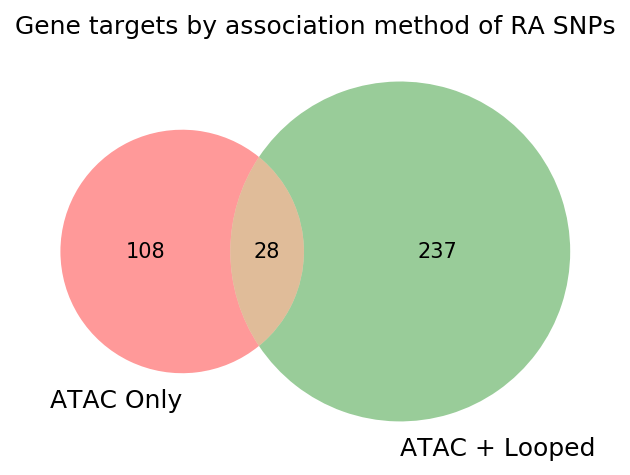

In [74]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=150)
venn2((atac_only, looped), set_labels=("ATAC Only", "ATAC + Looped"))
plt.title("Gene targets by association method of RA SNPs")
plt.show()

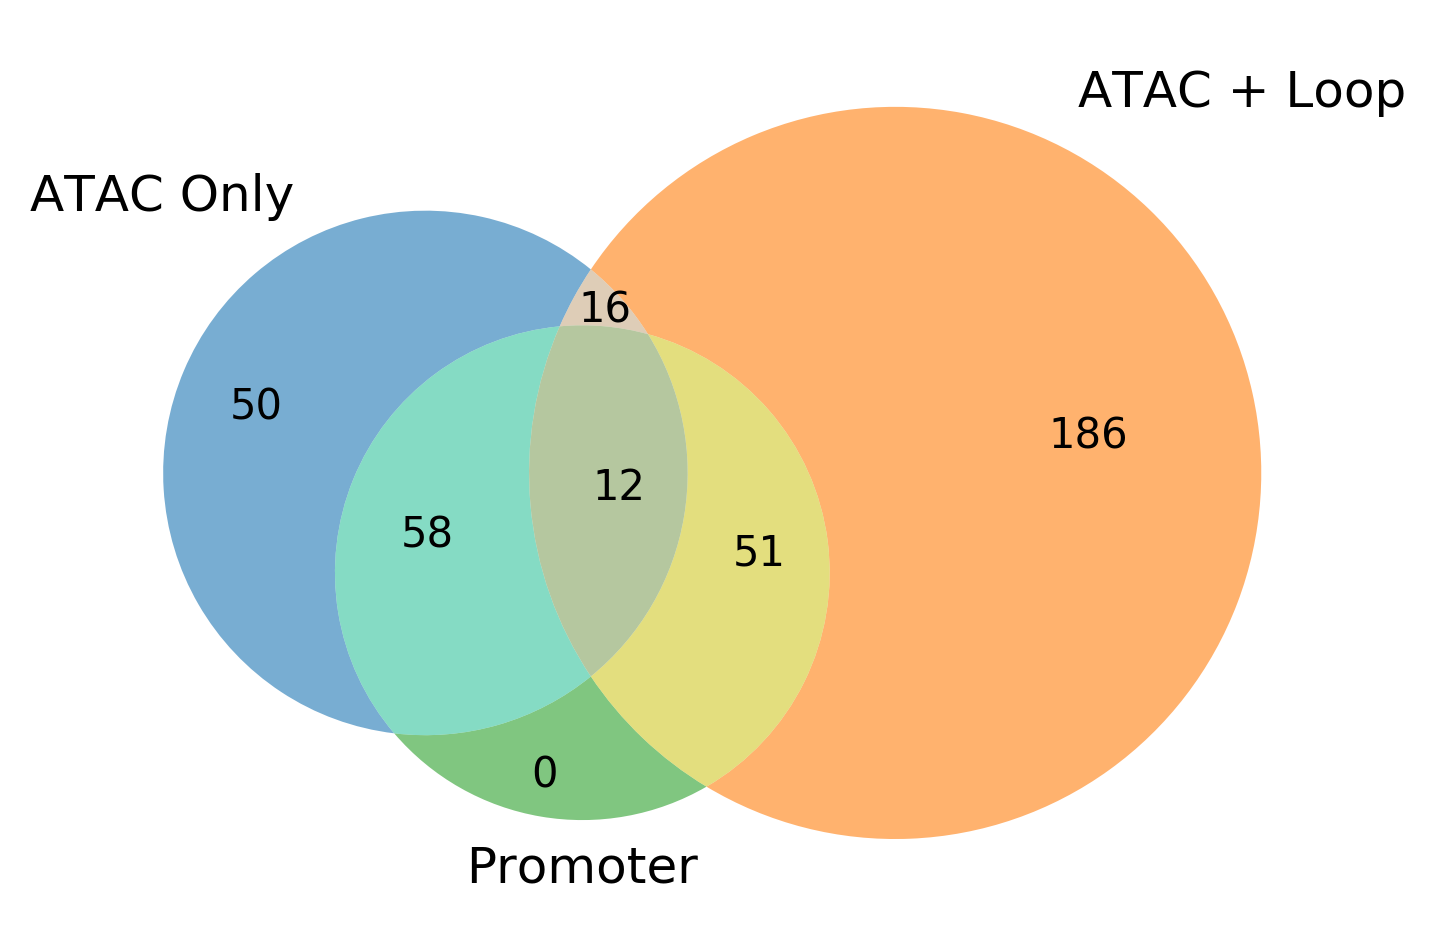

In [75]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
venn3((atac_only, #Remove all the weird genes (pseudogenes or other)
       looped,
      promoter),
     set_labels=("ATAC Only", "ATAC + Loop", "Promoter"), 
      set_colors=sns.palettes.color_palette()[:3], alpha=0.6, ax=ax)
# ax.set_title("Genes Targeted by >= 1 SNP", pad=20, size=20)
f.tight_layout()

Ok , so incorporating looping identifies novel target genes. Which are they? Do we have some examples of obvious importance?

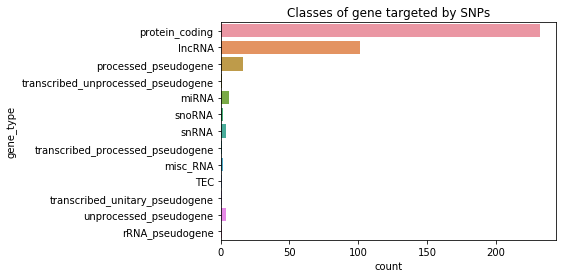

In [81]:
sns.countplot(data=all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(["name_gene"]), y="gene_type")
plt.title("Classes of gene targeted by SNPs")
plt.show()

# Load RPKM data

In [76]:
%cd /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [77]:
!pwd

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [78]:
th_rpkm = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/rna-seq/190311_human_th_rnaseq/rpkm_bygroup.tab")
th_rpkm.drop(columns=['Geneid', 'Length'], inplace=True)
th_rpkm = th_rpkm.dropna(subset=["gene_symbol"])

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


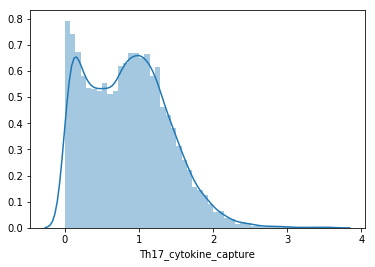

In [79]:
sns.distplot(np.log10(th_rpkm.Th17_cytokine_capture+1))

In [80]:
all_interactions_rpkm = pd.merge(all_interactions, th_rpkm, on='gene_symbol', how='left')
all_interactions_rpkm.to_csv("atac_snp_loop_ra/all_interactions_rpkm.tab", sep="\t", index=False)
all_interactions_rpkm

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped,description,Th1_cytokine_capture,Th1_standard,Th17_cytokine_capture,Th17_standard
0,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
1,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
2,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
3,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
4,chr1,1060000.0,1070000.0,chr1,1058908.0,1060229.0,chr1.1058909.1060229,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN
5,chr1,1060000.0,1070000.0,chr1,1063617.0,1064845.0,chr1.1063618.1064845,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN
6,chr1,1060000.0,1070000.0,chr1,1068561.0,1070150.0,chr1.1068562.1070150,loop.0,right,chr1,...,PERM1,protein_coding,False,False,True,NaN,NaN,NaN,NaN,NaN
7,chr1,1120000.0,1125000.0,chr1,1121668.0,1122974.0,chr1.1121669.1122974,loop.1,left,chr1,...,TNFRSF18,protein_coding,False,False,True,TNF receptor superfamily member 18 [Source:HGN...,36.415398,9.411021,43.451214,9.871080
8,chr1,1205000.0,1210000.0,chr1,1207942.0,1209199.0,chr1.1207943.1209199,loop.1,right,chr1,...,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN
9,chr1,1120000.0,1125000.0,chr1,1121668.0,1122974.0,chr1.1121669.1122974,loop.2,left,chr1,...,B3GALT6,protein_coding,False,False,True,"beta-1,3-galactosyltransferase 6 [Source:HGNC ...",9.910156,7.159846,7.532108,6.526830


In [81]:
all_interactions_rpkm.dropna(subset=['name_snp']).to_csv("atac_snp_loop_ra/all_interactions_with_snp.tab", sep="\t", index=False)

## Pivoting by genes or SNPs

In [82]:
filtered_linkage = pd.read_table("atac_snp_loop_ra/all_interactions_with_snp.tab")

In [83]:
filtered_linkage.shape

(1344, 34)

In [85]:
snp_info = pd.read_csv("ld_expansion_ra/ld_snps_info_new.tab", 
                       sep="\t").drop(columns=['synonyms', 'chrom', 'start', 'end'])

In [86]:
snp_info_cols = snp_info.columns.tolist()

In [87]:
snp_info_cols

['d_prime',
 'query',
 'r2',
 'result',
 'MAF',
 'allele_string',
 'consequence',
 'minor_allele',
 'snp_id']

In [88]:
snp_info_cols[0] = "lead_snp"
snp_info.columns = snp_info_cols

In [89]:
snp_info.drop_duplicates(subset=['lead_snp', 'result'])

,lead_snp,query,r2,result,MAF,allele_string,consequence,minor_allele,snp_id
0,0.983559,rs42041,0.809796,rs535369995,0.13540,A/C,intron_variant,C,rs535369995
1,0.989000,rs42041,0.811234,rs56201652,0.22160,G/A,intron_variant,A,rs56201652
2,0.999999,rs42041,0.821761,rs42044,0.18350,T/G,intron_variant,G,rs42044
3,0.989053,rs42041,0.818869,rs6960181,0.13500,C/T,intron_variant,T,rs6960181
4,1.000000,rs42041,0.975204,rs42035,0.14340,A/G/T,3_prime_UTR_variant,G,rs42035
5,0.983604,rs42041,0.813639,rs11764331,0.13540,C/T,intron_variant,T,rs11764331
6,1.000000,rs42041,1.000000,rs42043,0.17450,A/G,intron_variant,G,rs42043
7,0.999999,rs42041,0.821761,rs10953072,0.19230,A/C/T,intron_variant,C,rs10953072
8,0.994908,rs42041,0.970181,rs42034,0.14400,A/G,3_prime_UTR_variant,G,rs42034
9,0.989025,rs42041,0.815037,rs11767704,0.15400,C/T,intron_variant,T,rs11767704


In [90]:
filter_w_info = filtered_linkage.merge(snp_info, 
                                       left_on="name_snp", 
                                       right_on="result").drop(columns=['result', 'snp_id', 'score_gene', 'score'])

In [91]:
filter_w_info.to_csv("atac_snp_loop_ra/all_interactions_with_snp_info.tab", sep="\t", index=None)

In [92]:
# Get sorted list of genes with largest number of SNPs, removing duplicate gene-snp records
sorted_gene_by_n_snp = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_gene').size().sort_values(ascending=False)

In [93]:
filtered_linkage['th1_max_rpkm'] = filtered_linkage.loc[:,['Th1_cytokine_capture', 'Th1_standard']].max(axis=1)
filtered_linkage['th17_max_rpkm'] = filtered_linkage.loc[:,['Th17_cytokine_capture', 'Th17_standard']].max(axis=1)

In [94]:
# Produce a pivot table sorted by number of SNPs per gene
linkage_pivot_genes = filtered_linkage.pivot_table(index=['name_gene'], aggfunc={'name_snp' : lambda x: ';'.join(x),
                                                                                         'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max})
linkage_pivot_genes = linkage_pivot_genes.iloc[linkage_pivot_genes.index.get_level_values(level=0).reindex(sorted_gene_by_n_snp.index)[1]]

In [95]:
linkage_pivot_genes['n_snps'] = linkage_pivot_genes['name_snp'].str.split(';').apply(lambda x: len(np.unique(x)))

In [96]:
linkage_pivot_genes.head()

,gene_symbol,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,
ENSG00000276410.3,H2BC3,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000286522.1,H3C2,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000227507.2,LTB,rs140646916;rs560530;rs111394249;rs661330;rs57...,1052.732148,264.943496,21
ENSG00000234816.2,H2AC5P,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000204482.10,LST1,rs140646916;rs560530;rs111394249;rs661330;rs57...,5.377397,3.199796,21


In [97]:
sorted_gene_by_n_snp

name_gene
ENSG00000276410.3     21
ENSG00000286522.1     21
ENSG00000227507.2     21
ENSG00000234816.2     21
ENSG00000204482.10    21
ENSG00000204475.10    21
ENSG00000278463.1     21
ENSG00000278705.1     21
ENSG00000232810.4     21
ENSG00000287080.1     21
ENSG00000207110.1     15
ENSG00000249859.11    15
ENSG00000225914.3     15
ENSG00000196735.13    14
ENSG00000254275.6     13
ENSG00000204287.14    11
ENSG00000131979.19    11
ENSG00000027075.15    10
ENSG00000163947.11    10
ENSG00000107485.18    10
ENSG00000114541.15     9
ENSG00000226990.1      9
ENSG00000271251.1      9
ENSG00000134460.18     9
ENSG00000214015.3      9
ENSG00000155849.15     9
ENSG00000164091.12     8
ENSG00000250562.1      8
ENSG00000164088.18     8
ENSG00000235978.6      8
                      ..
ENSG00000204084.13     1
ENSG00000204301.6      1
ENSG00000228432.1      1
ENSG00000228414.7      1
ENSG00000228353.1      1
ENSG00000227907.1      1
ENSG00000227842.1      1
ENSG00000227039.6      1
ENSG00000226573

In [98]:
linkage_pivot_genes.to_excel("atac_snp_loop_ra/linkage_pivot_genes.xlsx")

In [99]:
sorted_snp_by_n_gene = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_snp').size().sort_values(ascending=False)
linkage_pivot_snps = filtered_linkage.pivot_table(index=['name_snp', 'name_gene'], aggfunc={'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max,
                                                                                           'is_looped' : np.mean})
linkage_pivot_snps = linkage_pivot_snps.iloc[linkage_pivot_snps.index.get_level_values(level=0).reindex(sorted_snp_by_n_gene.index)[1]]

In [100]:
linkage_pivot_snps.to_excel('atac_snp_loop_ra/linkage_pivot_snps.xlsx')

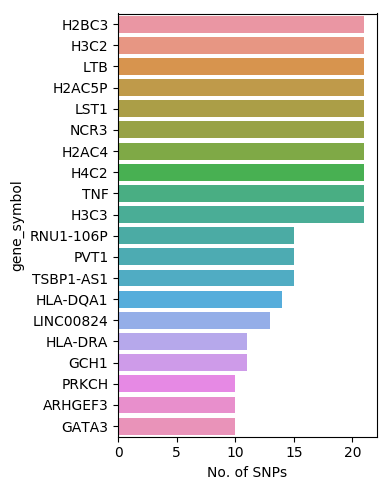

In [101]:
f, ax = plt.subplots(1,1,figsize=(4,5), dpi=100)
sns.barplot(data=linkage_pivot_genes[:20], y='gene_symbol', x="n_snps", ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("No. of SNPs")
f.tight_layout()

In [102]:
filtered_nodup = filtered_linkage[['name_gene', 'name_snp', 'is_looped', 'is_lead_snp', 'gene_symbol']].drop_duplicates()

In [103]:
linkage_pivot_genes.head(20)

,gene_symbol,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,
ENSG00000276410.3,H2BC3,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000286522.1,H3C2,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000227507.2,LTB,rs140646916;rs560530;rs111394249;rs661330;rs57...,1052.732148,264.943496,21
ENSG00000234816.2,H2AC5P,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000204482.10,LST1,rs140646916;rs560530;rs111394249;rs661330;rs57...,5.377397,3.199796,21
ENSG00000204475.10,NCR3,rs140646916;rs560530;rs111394249;rs661330;rs57...,19.565316,6.142695,21
ENSG00000278463.1,H2AC4,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000278705.1,H4C2,rs140646916;rs560530;rs111394249;rs661330;rs57...,NaN,NaN,21
ENSG00000232810.4,TNF,rs140646916;rs560530;rs111394249;rs661330;rs57...,62.315754,44.043060,21


In [104]:
most_total_snps = linkage_pivot_genes.iloc[:20, 1].tolist()